In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def get_price_data(ticker, period="3y", interval="1d", close_only=True):
    yf_ticker = yf.Ticker(ticker)
    data = yf_ticker.history(period=period, interval=interval)
    if close_only:
        close_data = data[["Close"]].rename(columns={"Close": ticker})
        return close_data
    else:
        return data

def get_rf_rate(treasury_type="3m"):
    type_to_series = {
        "4wk": "DTB4WK",
        "3m": "DGS3MO",
        "6m": "DGS6MO",
        "1y": "DGS1",
        "3y": "DGS3",
        "5y": "DGS5",
        "7y": "DGS7",
        "10y": "DGS10",
    }
    series_id = type_to_series.get(treasury_type.lower())
    if not series_id:
        valid_options = ", ".join(f'"{option}"' for option in type_to_series.keys())
        raise ValueError(
            f"Treasury type '{treasury_type}' is not recognized. Valid options are: {valid_options}."
        )
    start = datetime.today() - timedelta(days=10)
    end = datetime.today()
    rate_data = pdr.get_data_fred(series_id, start, end)
    most_recent_rate = rate_data.iloc[-1, 0]
    most_recent_rate_pct = float(most_recent_rate) / 100  # type: ignore
    return most_recent_rate_pct

def get_market_return(market_ticker="^GSPC", period="10y"):
    end_date = pd.Timestamp.today()
    start_date = end_date - pd.DateOffset(years=int(period[:-1]))
    data = yf.download(market_ticker, start=start_date, end=end_date)
    data["Year"] = data.index.year
    annual_returns = []

    for year in range(start_date.year, end_date.year + 1):
        if year in data["Year"].values:
            yearly_data = data[data["Year"] == year]
            yearly_return = (
                yearly_data["Adj Close"][-1] / yearly_data["Adj Close"][0]
            ) - 1
            annual_returns.append(
                1 + yearly_return
            )

    # we use Geometric mean to account for compounding
    geom_mean_annual_return = np.prod(annual_returns) ** (1 / len(annual_returns)) - 1

    return float(geom_mean_annual_return)  # type: ignore

def calculate_capm(
    stock="AAPL",
    index="^GSPC",
    beta_period="3y",
    beta_interval="1wk",
    market_period="10y",
    treasury_type="3m",
):
    beta = calculate_beta(
        index=index,
        stock=stock,
        period=beta_period,
        interval=beta_interval,
        just_beta=True,
    )
    rf_rate = get_rf_rate(treasury_type=treasury_type)
    market_rate = get_market_return(market_ticker=index, period=market_period)
    equity_risk_premium = market_rate - rf_rate
    capm = rf_rate + (beta * equity_risk_premium)
    return capm


def get_russell1000_tickers():
    url = "https://en.wikipedia.org/wiki/Russell_1000_Index"
    tables = pd.read_html(url) 
    sp500_table = tables[2]  
    tickers = sp500_table["Ticker"].tolist()
    return tickers


def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(url)
    sp500_table = tables[0]
    tickers = sp500_table["Symbol"].tolist()
    return tickers

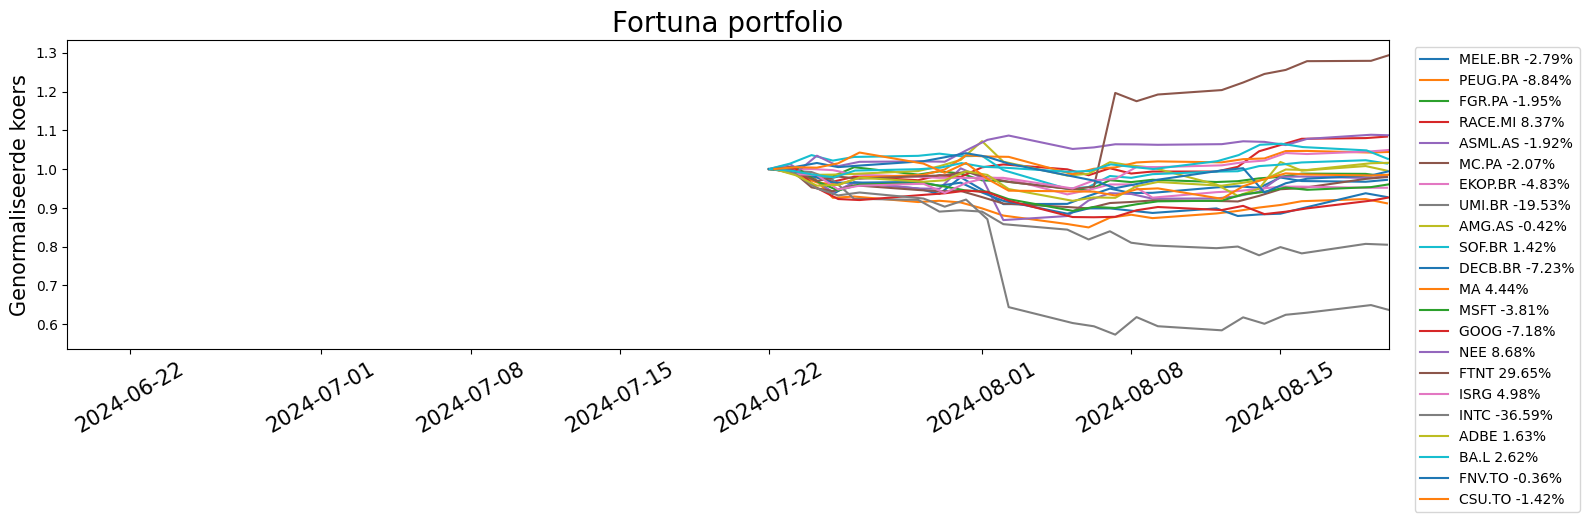

In [3]:
excelStocks = 'data\\Data2.xlsx'
df = pd.read_excel(excelStocks, sheet_name='Ticker')
dfTicker = pd.DataFrame(df, columns=['Ticker', 'Naam', 'Aantal'])

# Adjusting the figure size
fig = plt.subplots(figsize=(16, 5))


interval="1d"
period="1mo"

symbolnr = 0
for index, row in dfTicker.iterrows():
    symbol = row['Ticker']
    stock_data = get_price_data(symbol, period=period, interval=interval)

    stock_data[symbol] = stock_data[symbol] / stock_data[symbol][0]

    rendement = round( (stock_data[symbol][-1] - 1)*100, 2) 
    
    # Creating a plot
    plt.plot(stock_data.index, stock_data[symbol], label=symbol + ' ' + str(rendement) + '%')
    
    # Adding a plot title and customizing its font size
    plt.title('Fortuna portfolio', fontsize=20)
    
    # Adding axis labels and customizing their font size
    plt.xlabel('', fontsize=15)
    plt.ylabel('Genormaliseerde koers', fontsize=15)
    
    # Rotaing axis ticks and customizing their font size
    plt.xticks(rotation=30, fontsize=15)
    
    # Changing the plot resolution - zooming in the period from 15.12.2022 till 15.01.2023
    plt.xlim(pd.Timestamp('2024-06-19'), pd.Timestamp('2024-08-20'))

    plt.legend(bbox_to_anchor=(1.15, 1.0), loc = 'upper right')
    plt.tight_layout()







[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

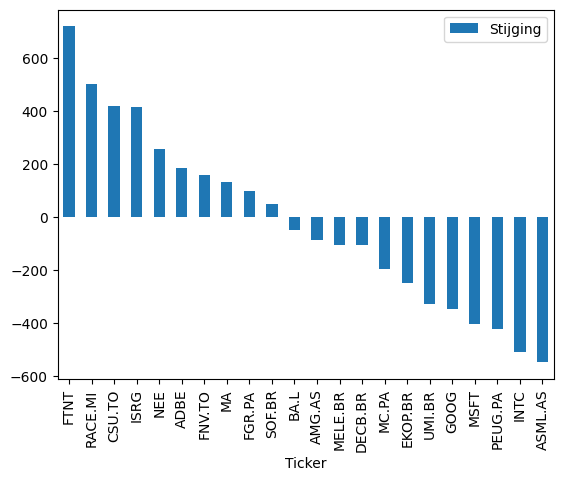

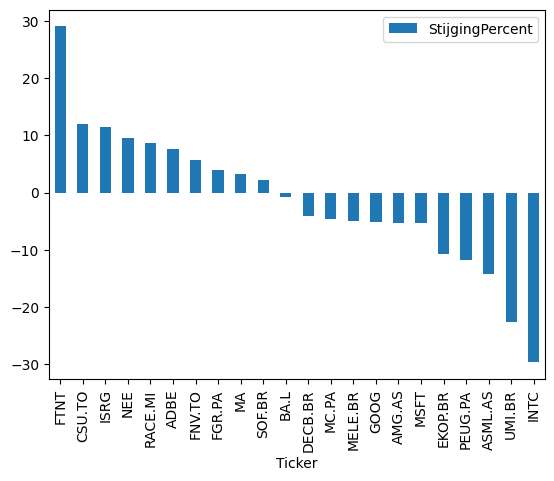

In [12]:
excelStocks = 'data\\Data2.xlsx'
df = pd.read_excel(excelStocks, sheet_name='Ticker')
dfTicker = pd.DataFrame(df, columns=['Ticker', 'Naam', 'Aantal', 'ConversieEur'])

interval="1d"
period="1mo"

dfStijging = pd.DataFrame(columns=['Ticker','Stijging'])
dfStijgingPercent = pd.DataFrame(columns=['Ticker','StijgingPercent'])

symbolnr = 0
for index, row in dfTicker.iterrows():
    symbol = row['Ticker']
    
    stock_data = yf.download(symbol, start="2024-06-19", end="2024-08-20")
    
    stijging = round( (stock_data["Close"][-1] - stock_data["Close"][0])*row['Aantal']*row['ConversieEur'], 2)    
    
    new_row = {'Ticker': symbol, 'Stijging': stijging}

    dfStijging.loc[len(dfStijging)] = new_row

    stijgingPercent = round( (stock_data["Close"][-1] / stock_data["Close"][0])*100 - 100 , 2) 
    
    new_row_percent = {'Ticker': symbol, 'StijgingPercent': stijgingPercent}

    dfStijgingPercent.loc[len(dfStijgingPercent)] = new_row_percent

dfStijging = dfStijging.sort_values("Stijging", ascending=False)
dfStijgingPercent = dfStijgingPercent.sort_values("StijgingPercent", ascending=False)



ax1 = dfStijging.plot.bar(x='Ticker', y='Stijging', rot=90)
ax2 = dfStijgingPercent.plot.bar(x='Ticker', y='StijgingPercent', rot=90)

In [ ]:
df